In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols

Dataset: https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

### Background
A fast-food chain plans to add a new item to its menu. They have three possible marketing campaigns designed to promote this new product. In order to determine which promotion has the greatest effect on sales, the new item was introduced at locations in several randomly selected markets. A different promotion was used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goals
1. Explore and visualize the data
2. Define metrics
3. Analyze the A/B test results and determine the best campaign (one that statistically performs better)

### Data dictionary
* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week


In [9]:
data = pd.read_csv('/WA_Marketing-Campaign.csv')
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


### Verify if the tests for all the three promotions are controlled through exploratory analysis

- Size of the groups
- Mean, median and std measures
- Sales based on age of the stores

In [11]:
#Grouping the data by Promotion
data_group = data.groupby(by=['Promotion'],axis=0)


#Aggregating the data to check the size of the groups and the data spread
data_group.SalesInThousands.agg(['count','sum','mean', 'median','std','min','max'])

,count,sum,mean,median,std,min,max
Promotion,,,,,,,
1,172,9993.03,58.099012,55.385,16.553782,30.81,99.65
2,188,8897.93,47.329415,45.385,15.108955,17.34,88.64
3,188,10408.52,55.364468,51.165,16.766231,22.18,96.48


<Axes: xlabel='AgeOfStore', ylabel='SalesInThousands'>

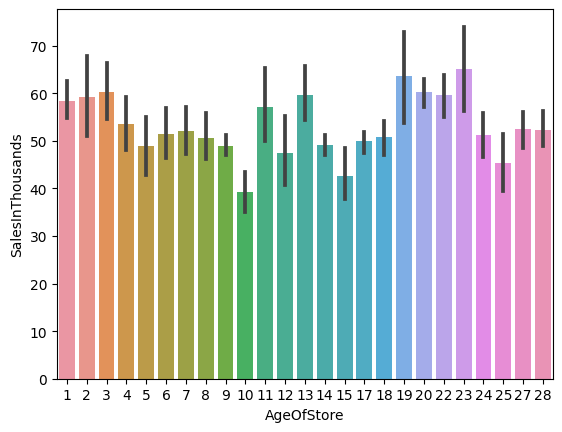

In [ ]:
#Looking at sales based on the age of the stores
sns.barplot(data,x='AgeOfStore',y= 'SalesInThousands')

### Metric of interest is total sales (revenue) for each of the promotions across 4 weeks per market size

In [18]:
#Grouping the data by other variables
data_groups = data.groupby(by=['Promotion', 'MarketSize','week'],axis=0)

print(data_groups.SalesInThousands.agg('sum'))

Promotion  MarketSize  week
1          Large       1       1050.59
                       2       1025.02
                       3       1056.64
                       4       1080.96
           Medium      1       1160.54
                       2       1111.52
                       3       1175.29
                       4       1129.22
           Small       1        293.38
                       2        311.43
                       3        295.39
                       4        303.05
2          Large       1        966.48
                       2        949.67
                       3        987.86
                       4        956.60
           Medium      1       1080.49
                       2       1079.23
                       3       1067.38
                       4        997.25
           Small       1        196.35
                       2        207.48
                       3        187.70
                       4        221.44
3          Large       1        956.

Promotions 1 and 3 tend to have generate more revenue than promotion 2


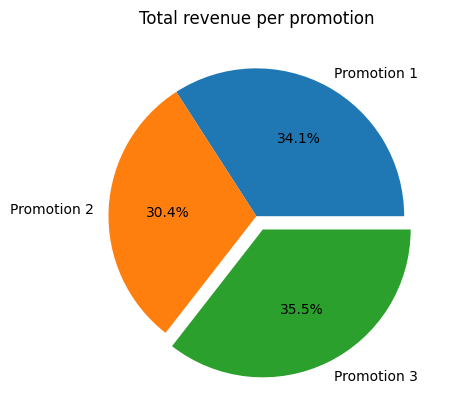

In [ ]:
x = data_group.SalesInThousands.agg(sum)
y = ['Promotion 1', 'Promotion 2', 'Promotion 3']
explode = [0, 0, 0.1]
plt.pie(x, labels=y, autopct='%1.1f%%', explode=explode)
plt.title("Total revenue per promotion")
plt.show()

### As the A/B tests seem to be controlled, it can be deduced that Promotion 3 performs better than Promotions 1 & 2.

The following will validate the above deduction based on statistical significance.

### Test for variance among the three campaign groups

**Null Hyptothesis**: There is no statistically significant variance among 3 promotion groups

Tests to perform


1.  ❌ t-test and Z-test - can be performed only for two groups (we have 3 promotion groups)/can be performed pairwise though
2. ✅ ANOVA - can be performed for 3 groups


ANOVA Assumptions - https://www.reneshbedre.com/blog/anova.html?utm_content=cmp-true

Assumption of normality: Residuals (experimental error) are approximately normally distributed (can be tested using Shapiro-Wilks test or histogram). Non-normality of the dependent variable can cause non-normality of residuals in ANOVA

Homogeneity of variance (homoscedasticity): Variances of dependent variable are roughly equal between treatment groups (can be tested using Levene’s, Bartlett’s, or Brown-Forsythe test)

Assumption of independence: Observations are sampled independently from each other (no relation in observations between the groups and within the groups) i.e., each subject should have only one response

The dependent variable should be continuous. If the dependent variable is ordinal or rank (e.g. Likert item data), it is more likely to violate the assumptions of normality and homogeneity of variances. If these assumptions are violated, you should consider the non-parametric tests (e.g. Mann-Whitney U test, Kruskal-Wallis test).



In [27]:
import pingouin as pg

pg.anova(dv='SalesInThousands',
         between='Promotion',
         data=data,
         detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Promotion,11449.174291,2,5724.587145,21.953486,6.765849e-10,0.074557
1,Within,142114.105414,545,260.759826,NaN,NaN,NaN


### Interpretation of results
1. **Since p (6.765849e-10) < 0.05 we can reject the null hypothesis and conclude that the promotions indeed have an impact on sales**
2. **eta squared is 0.07 and indicates that there is a medium effect between Promotion and the sales**

*Reference
η2 = 0.01 indicates a small effect;
η2 = 0.06 indicates a medium effect;
η2 = 0.14 indicates a large effect*

### Tests for Anova assumptions

In [29]:
#Test 1: Normality Assumption
formula = 'SalesInThousands ~ Promotion'

model = ols(formula, data=data).fit()
res = model.resid

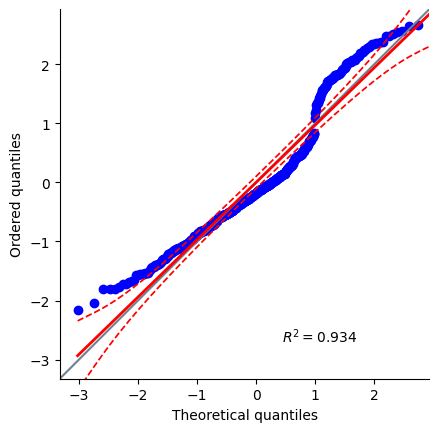

In [30]:
# QQ plot
ax = pg.qqplot(res, dist='norm')
sns.despine()

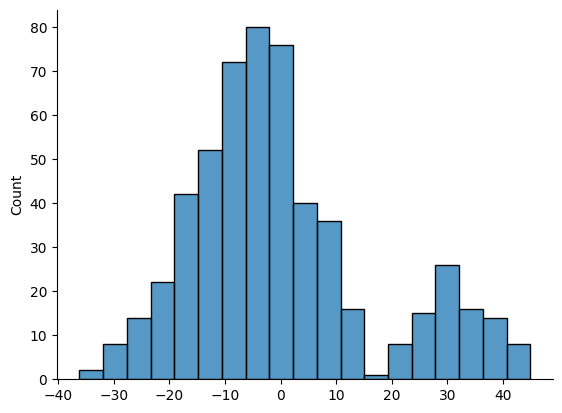

In [31]:
#histogram of residulas
ax = sns.histplot(res)
sns.despine()

Both QQ plot and the histograms show some deviations from the normal distribution.

In [35]:
#checking shapiro test values
shapiro(res)

ShapiroResult(statistic=0.9323780536651611, pvalue=4.927598077025894e-15)

Normality assumption cannot be met due to p-value being less than 0.05.

**Conclusion** - Since the assumption for normal distribution of residuals can't be met, non-parametric tests may be more suitable.